# **Problem statement:**

This project aims to build a predictive model to answer the critical question: "What factors influenced the likelihood of survival for passengers on the Titanic?". Utilizing historical passenger data, including features such as name, age, gender, and socio-economic class, the goal is to develop a model that accurately predicts the probability of survival for each individual. The insights gained from this analysis not only contribute to understanding the dynamics of the Titanic disaster but also have implications for future safety measures in maritime travel.

# **Data Collection**

In [1]:
### Importing necessery Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train_data=pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **Data Cleaning**

In [5]:
# Numerical informations of the train dataset
train_data.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
from sklearn.impute import SimpleImputer

def clean(data):
    # Remove unnecessary columns
    data = data.drop(columns=['Ticket', 'Cabin', 'Name', 'PassengerId'])

    # Impute missing values for numerical columns with median
    numerical_cols = ['SibSp', 'Parch', 'Fare', 'Age']
    numerical_imputer = SimpleImputer(strategy='median')
    data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])

    # Impute missing values for 'Embarked' with most frequent value
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    data['Embarked'] = categorical_imputer.fit_transform(data[['Embarked']]).ravel()

    return data


In [8]:
test_id = test_data['PassengerId']  # Extract 'PassengerId' from the test set
train_data = clean(train_data)  # Clean the training data using the clean function
test_data = clean(test_data)  # Clean the test data using the clean function
train_data.head(5)  # Display the first 5 rows of the cleaned training data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1.0,0.0,7.2500,S
1,1,1,female,38.0,1.0,0.0,71.2833,C
2,1,3,female,26.0,0.0,0.0,7.9250,S
3,1,1,female,35.0,1.0,0.0,53.1000,S
4,0,3,male,35.0,0.0,0.0,8.0500,S


In [9]:
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [10]:
test_data.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [11]:
train_data['Died'] = 1 - train_data['Survived']

In [12]:
#check all categories
train_data['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [13]:
# Calculate and print the survival rates for women and men
female_survival_rate = (train_data[train_data['Sex'] == 'female']['Survived'].sum() / len(train_data[train_data['Sex'] == 'female'])) * 100
male_survival_rate = (train_data[train_data['Sex'] == 'male']['Survived'].sum() / len(train_data[train_data['Sex'] == 'male'])) * 100

print("Survival rate for women: {:.2f}%".format(female_survival_rate))
print("Survival rate for men: {:.2f}%".format(male_survival_rate))

Survival rate for women: 74.20%
Survival rate for men: 18.89%


# Data Exploration/Analysis

**Survival based on Gender**

In [14]:
import plotly.express as px

fig = px.bar(train_data, x='Sex', y=['Survived', 'Died'], color='Sex',
             labels={'value': 'Number of Passengers'},
             color_discrete_map={'male': '#EB89B5', 'female': '#330C73'},
             title='Survivors and Non-Survivors Categorized by Gender'
            )

fig.update_layout(width=600)
fig.show()


**Survival based on Fare, Pclass, and Survived**

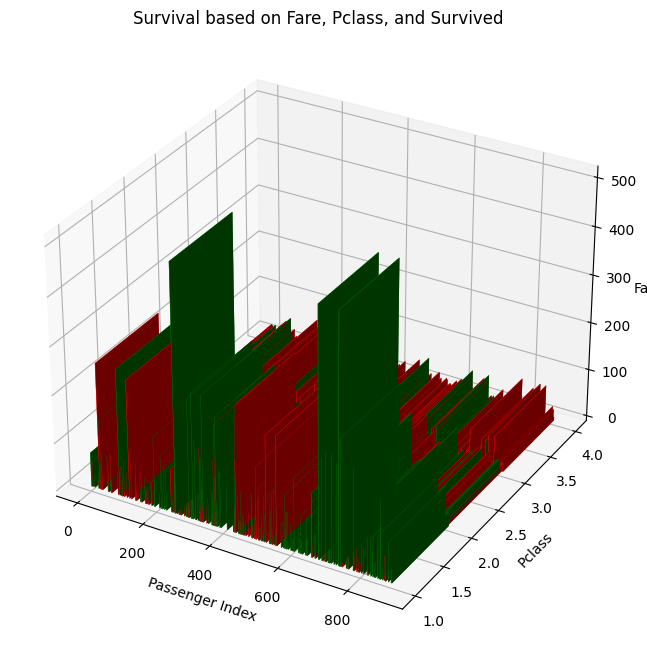

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

survived_colors = train_data['Survived'].map({0: 'red', 1: 'green'})

ax.bar3d(train_data.index, train_data['Pclass'], 0, 1, 1, train_data['Fare'],
         shade=True, color=survived_colors)

ax.set_xlabel('Passenger Index')  # Replace 'Passenger Index' with your actual x-axis label
ax.set_ylabel('Pclass')
ax.set_zlabel('Fare')
ax.set_title('Survival based on Fare, Pclass, and Survived')

plt.show()


**Survival based on Age of Passengers**

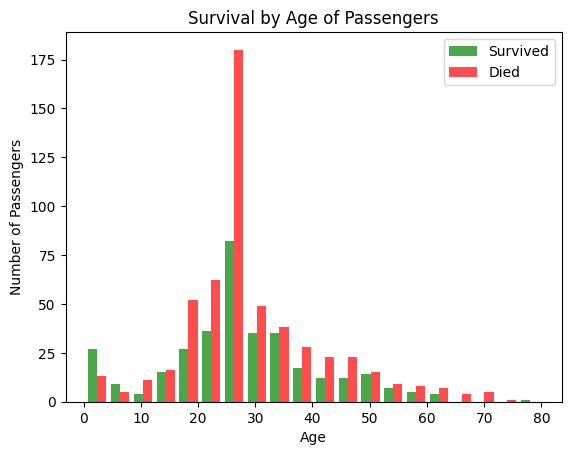

In [16]:
survived = train_data[train_data['Survived'] == 1]['Age'].dropna()
died = train_data[train_data['Survived'] == 0]['Age'].dropna()

plt.hist([survived, died], bins=20, color=['green', 'red'], alpha=0.7, label=['Survived', 'Died'])

plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.title('Survival by Age of Passengers')
plt.legend()

plt.show()


**Survival by Fare of Passengers**

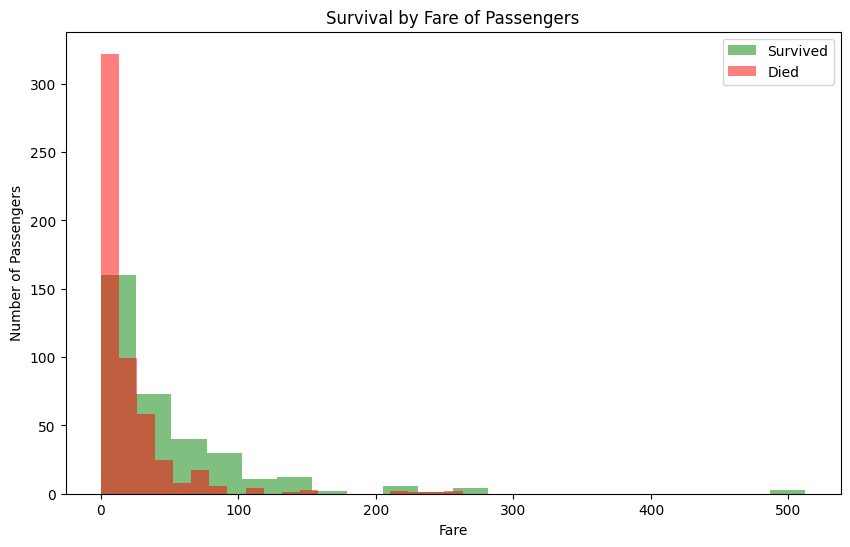

In [17]:
plt.figure(figsize=(10, 6))

plt.hist(train_data[train_data['Survived'] == 1]['Fare'], bins=20, color='green', alpha=0.5, label='Survived')
plt.hist(train_data[train_data['Survived'] == 0]['Fare'], bins=20, color='red', alpha=0.5, label='Died')

plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.title('Survival by Fare of Passengers')
plt.legend()

plt.show()


**Average Fare for Each Pclass**

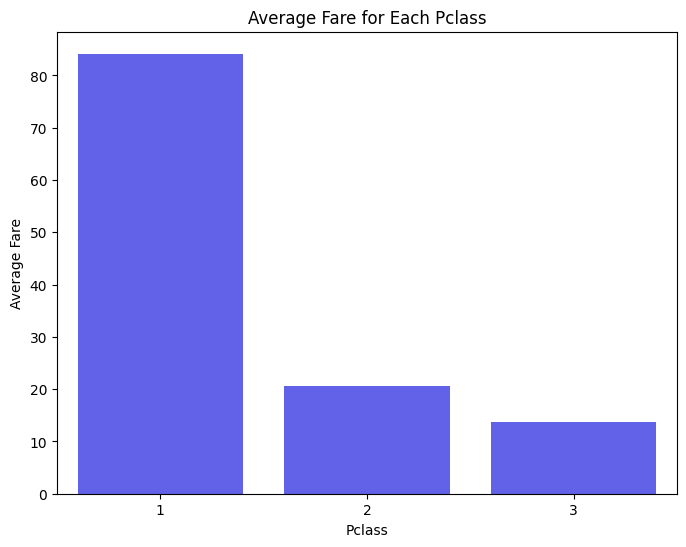

In [18]:
plt.figure(figsize=(8, 6))

sns.barplot(x='Pclass', y='Fare', data=train_data, ci=None, color='blue', alpha=0.7)

plt.xlabel('Pclass')
plt.ylabel('Average Fare')
plt.title('Average Fare for Each Pclass')

plt.show()


#  Encoding Categorical Variables

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cat_cols = ['Sex', 'Embarked']

for col in cat_cols:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    print(le.classes_)

train_data.head(5)


['female' 'male']
['C' 'Q' 'S']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Died
0,0,3,1,22.0,1.0,0.0,7.2500,2,1
1,1,1,0,38.0,1.0,0.0,71.2833,0,0
2,1,3,0,26.0,0.0,0.0,7.9250,2,0
3,1,1,0,35.0,1.0,0.0,53.1000,2,0
4,0,3,1,35.0,0.0,0.0,8.0500,2,1


**Survival Factors: Feature Correlations Heatmap**

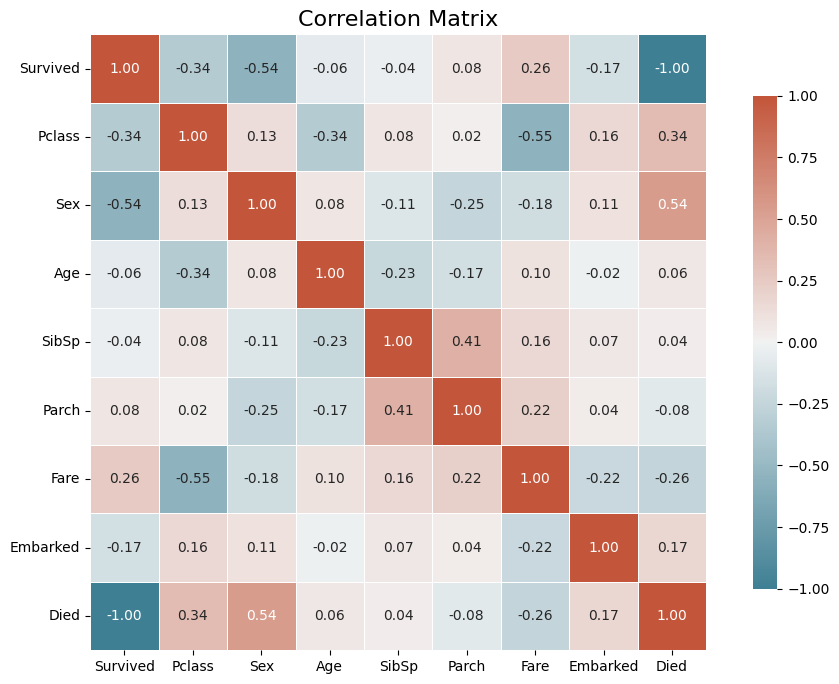

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a custom colormap for better visibility
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(train_data.corr(), annot=True, cmap=cmap, linewidths=.5, fmt=".2f",
            vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.8})

# Add title
plt.title('Correlation Matrix', fontsize=16)

# Rotate the y-axis labels for better readability
plt.yticks(rotation=0)

# Show the plot
plt.show()


# **Model Train, Evaluate and Comparison**

In [21]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split

X = train_data.drop(['Survived', 'Died'], axis=1)
y = train_data['Survived']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate_model function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    return accuracy, report

# Train and evaluate models
models = {'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
          'Random Forest': RandomForestClassifier(random_state=42),
          'Support Vector Machine': SVC(random_state=42, max_iter=1000)}

results = []

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_test_pred = model.predict(X_test)

    # Evaluate model
    accuracy, report = evaluate_model(y_test, y_test_pred)

    print(model_name, ':\n', report)
    print("Accuracy: {:.2%}".format(accuracy))
    print('='*40)

    # Store the results
    result = {'Model': model_name, 'Accuracy': accuracy}
    results.append(result)

# Create a DataFrame from the results
result_data = pd.DataFrame(results)
table_output = result_data[['Model', 'Accuracy']].sort_values(by='Accuracy', ascending=False)
table_output['Accuracy'] = table_output['Accuracy'].apply(lambda x: "{:.2%}".format(x))  # Format accuracy as percentage
print(table_output)

# Find the most accurate model
most_accurate_model = result_data.loc[result_data['Accuracy'].idxmax(), 'Model']

# Print the observation
print(f"From the results, it appears that the {most_accurate_model} model is the most accurate among the tested models.")


Logistic Regression :
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Accuracy: 81.01%
Random Forest :
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

Accuracy: 82.12%
Support Vector Machine :
               precision    recall  f1-score   support

           0       0.64      0.94      0.76       105
           1       0.76      0.26      0.38        74

    accuracy                           0.66       179
   macro avg       0.70     

# Best Model Predictions on Test Data

In [22]:
def train_and_predict_best_model(X_train, y_train, test_data, model_instance):
    # Train the model
    model_instance.fit(X_train, y_train)

    # Predict on the test set
    test_predictions = model_instance.predict(test_data)

    # Create a DataFrame for predictions
    prediction_data = pd.DataFrame({'PassengerId': test_id, 'Survived': test_predictions})

    return prediction_data

# Use the function with the best model
best_model_instance = models[most_accurate_model]
predictions_data = train_and_predict_best_model(X_train, y_train, test_data, best_model_instance)

# Display the first 10 rows of predictions
predictions_data.head(10)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [23]:
predictions_data.to_csv('submission.csv', index=False)

# Display a message indicating successful file saving
print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'
